# Acne Grading Classifier

In [25]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
from tensorflow.keras.layers import BatchNormalization, Dropout
from tensorflow.keras.models import Sequential

In [4]:
BATCH_SIZE = 32
IMAGE_SIZE = 256
CHANNELS = 3 #rgb channel
EPOCHS = 20

In [5]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
"Dataset",
shuffle=True,
image_size=(IMAGE_SIZE,IMAGE_SIZE),
batch_size=BATCH_SIZE
)
#Loads all images and divides them into 32 batches internally

Found 999 files belonging to 3 classes.


In [6]:
class_names = dataset.class_names
class_names

['Level_0', 'Level_1', 'Level_2']

In [7]:
dataset.take(1) #returns batch of 32 data

<_TakeDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [8]:
for image_batch, labels_batch in dataset.take(1):
    print(image_batch.shape)
    print(labels_batch.numpy())

(32, 256, 256, 3)
[1 1 1 1 0 0 1 0 0 0 1 2 0 1 0 0 1 1 1 2 0 0 2 2 0 0 0 1 0 1 1 2]


(32, 256, 256, 3)
[1 1 1 0 0 1 0 0 2 1 1 1 1 1 2 1 2 1 1 1 2 2 2 0 1 2 0 0 2 0 1 0]


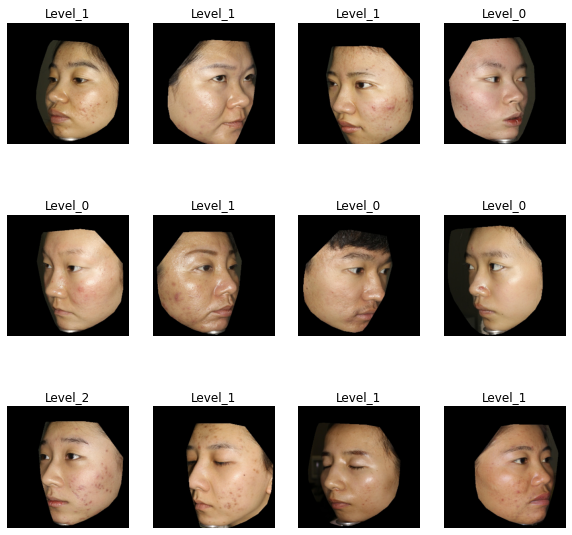

In [9]:
plt.figure(figsize=(10,10)) #size of image
for image_batch, labels_batch in dataset.take(1):
    print(image_batch.shape)
    print(labels_batch.numpy())
    for i in range(12): #will print 12 images
        ax = plt.subplot(3,4,i+1) #will print in 3*4 matrix format
        plt.imshow(image_batch[i].numpy().astype("uint8")) #converting the tensor object into numpy and then unto int8
        plt.title(class_names[labels_batch[i]])
        plt.axis("off") #eliminates the axis around, so only image is displayed

In [10]:
#Function to split the dataset into training, testing and validation data
def get_partitions(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split+val_split+test_split) == 1
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
        
    train_size = int(train_split*ds_size)
    val_size = int(val_split*ds_size)
    
    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [11]:
train_ds, val_ds, test_ds = get_partitions(dataset) #extracting all three datasets by splitting

In [12]:
len(train_ds) #length of training dataset

25

In [13]:
len(test_ds) #Length of testing dataset

4

In [14]:
len(val_ds) #Length of validation dataset

3

In [15]:
train_ds = train_ds.cache().shuffle(500).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(500).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(500).prefetch(buffer_size=tf.data.AUTOTUNE)

In [32]:
#Creating layers in keras for scaling data
resize_and_rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    layers.experimental.preprocessing.Rescaling(1.0/255)
])
     


In [33]:
#Data Augmentation Layer for flipping and rotation
data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2)
])


In [34]:

input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 3
model = models.Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(32, kernel_size=(3,3), activation='relu',input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, kernel_size=(3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, kernel_size=(3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, kernel_size=(3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, kernel_size=(3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, kernel_size=(3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])
model.build(input_shape=input_shape)

In [35]:
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_4 (Sequential)   (32, 256, 256, 3)         0         
                                                                 
 sequential_5 (Sequential)   (32, 256, 256, 3)         0         
                                                                 
 conv2d_12 (Conv2D)          (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d_10 (MaxPooli  (32, 127, 127, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_13 (Conv2D)          (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_11 (MaxPooli  (32, 62, 62, 64)          0         
 ng2D)                                                

In [36]:

model.compile(
    optimizer = 'adam',
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [37]:
from tensorflow.python.ops.gen_batch_ops import batch
history = model.fit(
   train_ds,
   epochs = EPOCHS ,
   batch_size = BATCH_SIZE ,
   verbose = 1,
   validation_data = val_ds
)

Epoch 1/20
25/25 [==============================] - 39s 1s/step - loss: 1.0289 - accuracy: 0.4288 - val_loss: 1.0328 - val_accuracy: 0.4062
Epoch 2/20
25/25 [==============================] - 37s 1s/step - loss: 1.0031 - accuracy: 0.4563 - val_loss: 1.0270 - val_accuracy: 0.4062
Epoch 3/20
25/25 [==============================] - 44s 2s/step - loss: 1.0006 - accuracy: 0.4325 - val_loss: 1.0404 - val_accuracy: 0.4062
Epoch 4/20
25/25 [==============================] - 37s 1s/step - loss: 1.0038 - accuracy: 0.4613 - val_loss: 1.0235 - val_accuracy: 0.4062
Epoch 5/20
25/25 [==============================] - 42s 2s/step - loss: 0.9996 - accuracy: 0.4100 - val_loss: 1.0361 - val_accuracy: 0.4062
Epoch 6/20
25/25 [==============================] - 38s 2s/step - loss: 1.0008 - accuracy: 0.4613 - val_loss: 1.0210 - val_accuracy: 0.4688
Epoch 7/20
25/25 [==============================] - 33s 1s/step - loss: 0.9952 - accuracy: 0.4288 - val_loss: 1.0407 - val_accuracy: 0.4062
Epoch 8/20
25/25 [==

In [38]:
scores = model.evaluate(test_ds)

4/4 [==============================] - 1s 357ms/step - loss: 0.9540 - accuracy: 0.4609


In [ ]:
scores

In [ ]:
history

In [ ]:
history.params

In [131]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [132]:
len(history.history['loss'])

20

In [133]:
history.history['accuracy']

[0.41749998927116394,
 0.41874998807907104,
 0.45750001072883606,
 0.45375001430511475,
 0.47749999165534973,
 0.45500001311302185,
 0.4762499928474426,
 0.45875000953674316,
 0.4399999976158142,
 0.5087500214576721,
 0.45249998569488525,
 0.44999998807907104,
 0.4724999964237213,
 0.4925000071525574,
 0.4749999940395355,
 0.4762499928474426,
 0.4699999988079071,
 0.4699999988079071,
 0.518750011920929,
 0.4925000071525574]

In [134]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

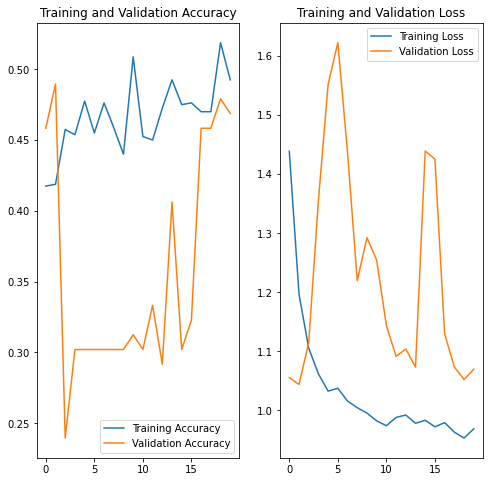

In [135]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

First image to predict
Actual Label: Level_1
1/1 [==============================] - 0s 484ms/step
Predicted Label: Level_1


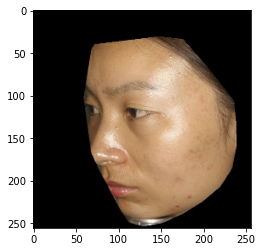

In [138]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):
    first_image = images_batch[0].numpy().astype("uint8")
    
    print("First image to predict")
    plt.imshow(first_image)
    print("Actual Label:",class_names[labels_batch[0].numpy()])
    
    batch_prediction = model.predict(images_batch)
    print("Predicted Label:",class_names[np.argmax(batch_prediction[0])])

In [139]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0) #create a batch
    
    predictions = model.predict(img_array)
    
    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 [==============================] - 0s 50ms/step


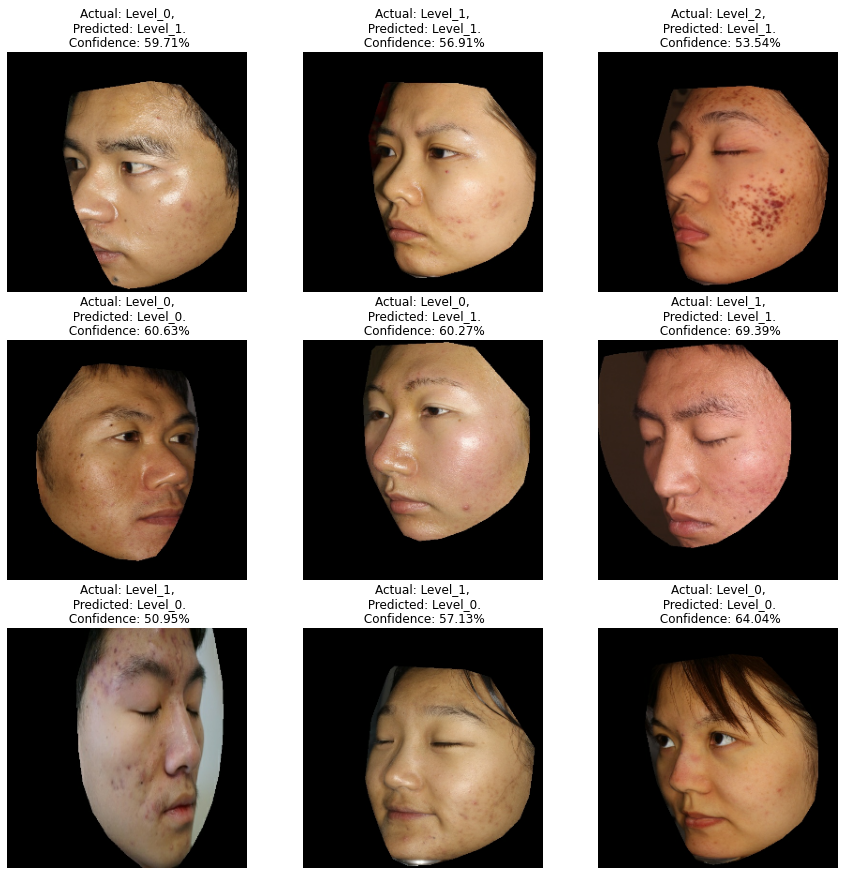

In [142]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i+1)
        plt.imshow(images[i].numpy().astype("uint8"))
        predicted_class, confidence = predict(model, images[i].numpy())
        
        actual_class = class_names[labels[i]]
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        plt.axis("off")

In [144]:
model_version = 1
model_path = f"../models/{model_version}"
model.save(model_path)

INFO:tensorflow:Assets written to: ../models/1\assets


INFO:tensorflow:Assets written to: ../models/1\assets
